In [9]:
import numpy as np
import matplotlib.pyplot as plt

In [11]:
d = 2
mu = np.random.random(size=(d))
sigma = np.array([
    [1, 0.4], 
    [0.4, 1]
])

test_data = np.random.multivariate_normal(mu, sigma, size=1_000)

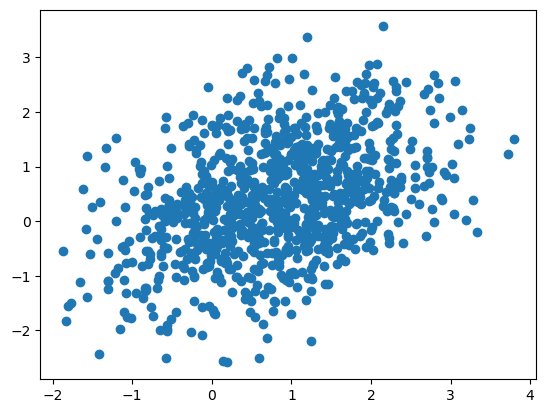

In [12]:
plt.scatter(test_data[:,0], test_data[:,1])

In [13]:
from scipy.stats._continuous_distns import chi2

alpha = 0.05
mu = np.mean(test_data, axis=0)
cov = np.cov(test_data.T)
sqrt_cov_inv = np.linalg.cholesky(np.linalg.inv(cov))
cutoff = np.sqrt(chi2.ppf(q=1 - alpha, df=mu.shape[0]))

In [14]:
in_region = lambda x : np.linalg.norm((x - mu).T @ sqrt_cov_inv) <= cutoff

In [28]:
def repeat_product(x, y):
    return np.transpose([np.tile(x, len(y)), 
                        np.repeat(y, len(x))])

In [39]:
xx = np.arange(-4, 4, 0.1)
yy = np.arange(-4, 4, 0.1)
zz = repeat_product(xx, yy)

In [40]:
contained = [in_region(z) for z in zz]

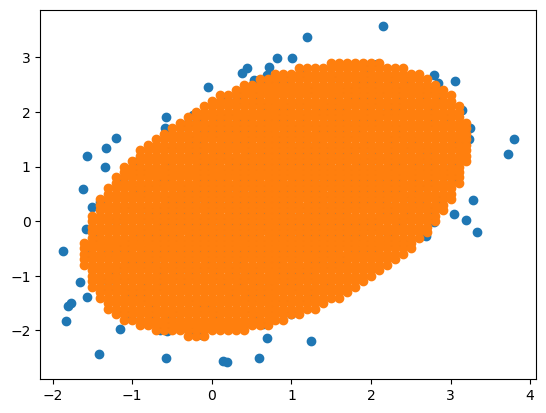

In [41]:
plt.scatter(test_data[:,0], test_data[:,1])
plt.scatter(zz[contained][:,0], zz[contained][:,1])